In [56]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [2]:
df = pd.read_csv('./data/nyc_energy_consumption.csv')
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [5]:

df['timeStamp']=pd.to_datetime(df['timeStamp'])

ny_df=df.set_index('timeStamp')

In [6]:
ny_df.resample('D').mean()
     

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


In [ ]:
ny_df_daily=ny_df.resample('D').mean()

In [8]:
ny_df_final=ny_df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')

In [9]:
ny_df_final

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833
...,...,...
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,NaN


In [10]:
train=ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test=ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

In [11]:

train.shape

(1947, 2)

In [21]:
train

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833
...,...,...
1942,2017-04-26,5342.687591
1943,2017-04-27,5445.442917
1944,2017-04-28,5648.995917
1945,2017-04-29,5467.143125


In [12]:
test.shape

(104, 2)

In [13]:
test

,ds,y
1947,2017-05-01,5417.231583
1948,2017-05-02,5697.950042
1949,2017-05-03,5354.628500
1950,2017-05-04,5235.704833
1951,2017-05-05,5358.639500
...,...,...
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,NaN


In [14]:
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [15]:
m.fit(train)

12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
m.params

OrderedDict([('lp__', array([[5009.88]])),
             ('k', array([[0.0885303]])),
             ('m', array([[0.593289]])),
             ('delta',
              array([[-8.51377e-08, -4.46024e-04, -1.00778e-01, -9.10087e-08,
                       2.08754e-08,  2.84313e-07,  1.81086e-08, -1.02157e-07,
                      -2.72908e-08, -3.77655e-08, -2.69110e-02, -7.17684e-02,
                      -2.08567e-07, -4.81343e-08,  2.30977e-01,  2.12849e-06,
                      -3.80712e-07, -8.58136e-02, -4.35610e-02,  2.02909e-08,
                       2.46565e-08,  2.03889e-08,  2.76521e-03,  1.22544e-02,
                       5.24778e-08]])),
             ('sigma_obs', array([[0.0459738]])),
             ('beta',
              array([[-0.0345704 , -0.0705133 ,  0.0576085 ,  0.0470652 , -0.014056  ,
                      -0.00500044, -0.00386426, -0.0007405 ,  0.00242043, -0.00755564,
                       0.00405483,  0.00483132, -0.00789636, -0.00470438,  0.00701818,
          

In [26]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [28]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7590.895873,6716.603495,8496.783173
2047,2017-08-09,7580.018324,6586.739919,8477.667357
2048,2017-08-10,7534.743337,6607.565330,8383.071880
2049,2017-08-11,7489.968485,6608.020013,8465.250292
2050,2017-08-12,6915.155942,6024.304212,7787.854835


<Axes: xlabel='ds'>

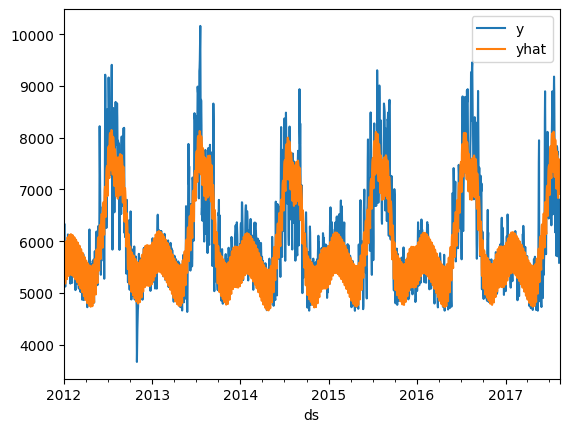

In [19]:
pd.concat([ny_df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

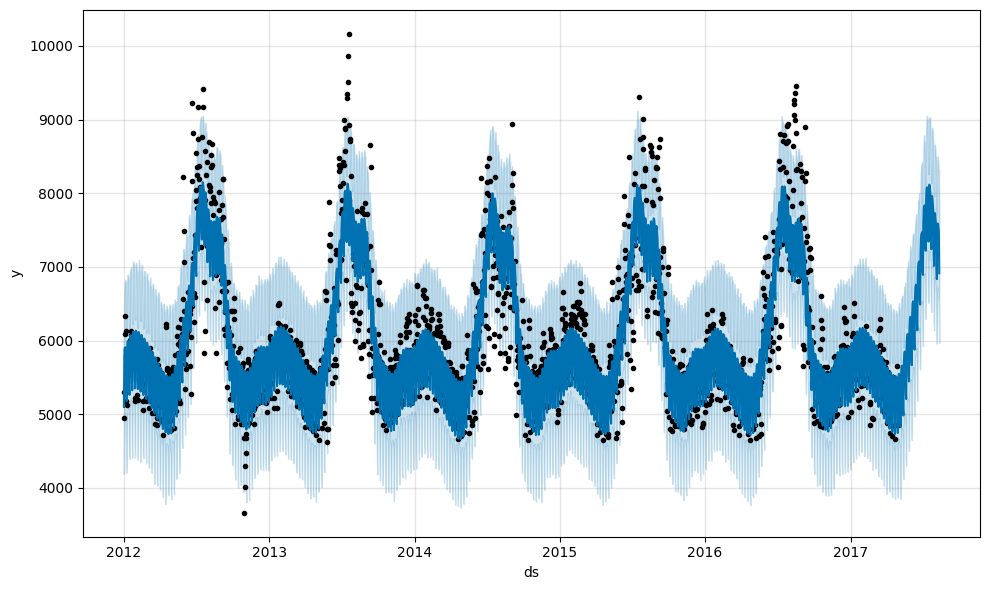

In [20]:
fig1 = m.plot(forecast)

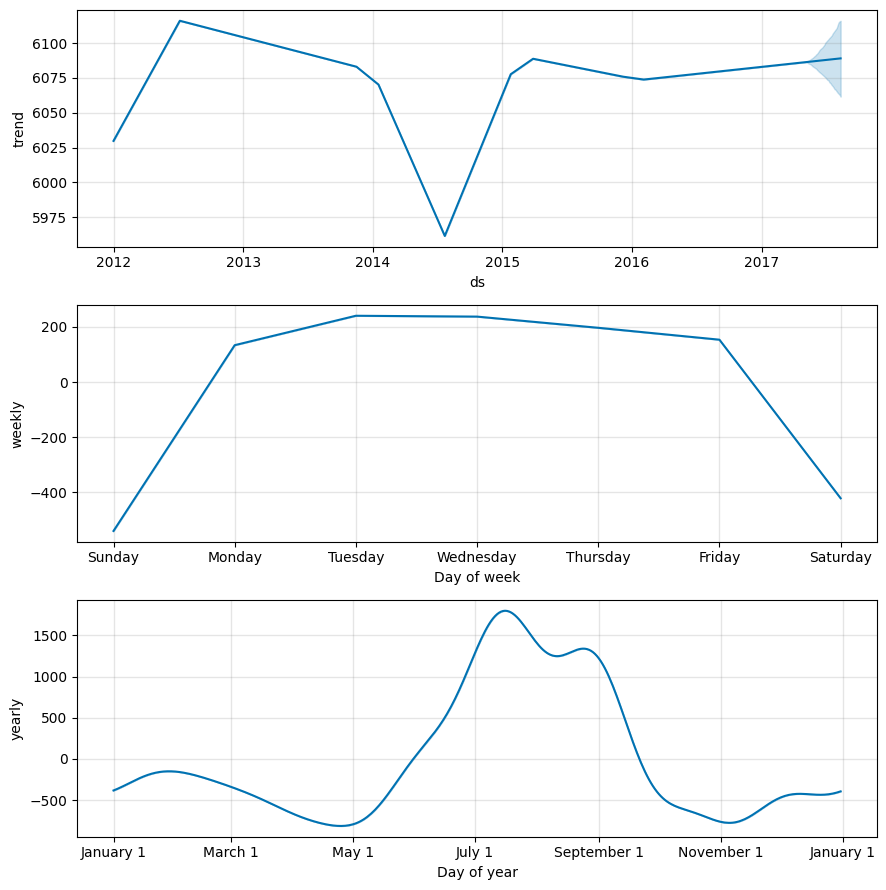

In [29]:
fig2 = m.plot_components(forecast)

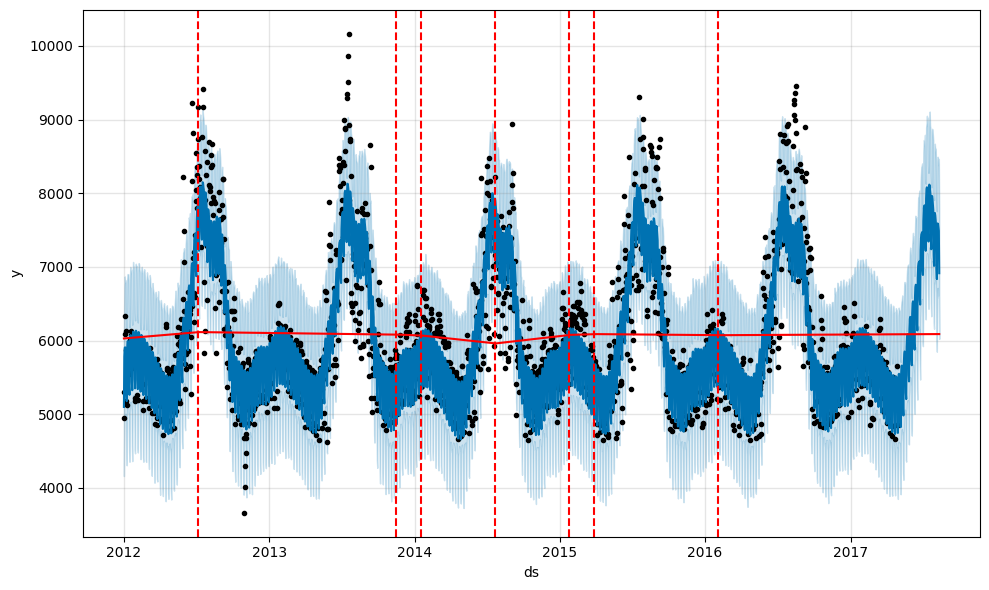

In [31]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [32]:
deltas = m.params['delta'].mean(0)
deltas

array([-8.51377e-08, -4.46024e-04, -1.00778e-01, -9.10087e-08,
        2.08754e-08,  2.84313e-07,  1.81086e-08, -1.02157e-07,
       -2.72908e-08, -3.77655e-08, -2.69110e-02, -7.17684e-02,
       -2.08567e-07, -4.81343e-08,  2.30977e-01,  2.12849e-06,
       -3.80712e-07, -8.58136e-02, -4.35610e-02,  2.02909e-08,
        2.46565e-08,  2.03889e-08,  2.76521e-03,  1.22544e-02,
        5.24778e-08])

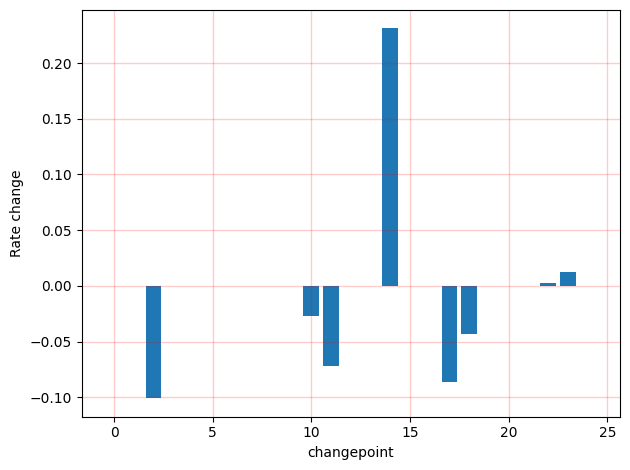

In [47]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('changepoint')
fig.tight_layout();

In [48]:
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing


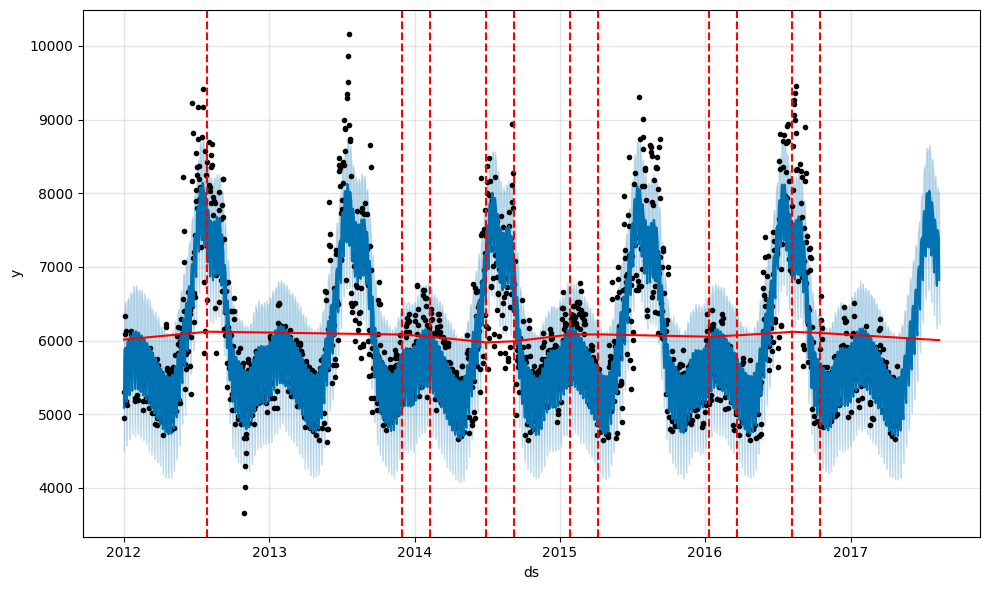

In [49]:
pro_change= Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [52]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2012, 1, 1, 0, 0),
                          datetime.datetime(2012, 1, 2, 0, 0),
                          datetime.datetime(2012, 1, 3, 0, 0), ...,
                          datetime.datetime(2017, 4, 28, 0, 0),
                          datetime.datetime(2017, 4, 29, 0, 0),
                          datetime.datetime(2017, 4, 30, 0, 0)], dtype=object),
              'y': array([4954.83333333, 5302.95416667, 6095.5125    , ..., 5648.99591667,
                          5467.143125  , 4855.9545    ])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2012, 1, 1, 0, 0),
                          datetime.datetime(2012, 1, 2, 0, 0),
                          datetime.datetime(2012, 1, 3, 0, 0), ...,
                          datetime.datetime(2017, 8, 10, 0, 0),
                          datetime.datetime(2017, 8, 11, 0, 0),
                          datetime.datetime(2017, 8, 12, 0, 0)], dtype=object),
              'y': array([4495.23949791, 5120.3253394 , 5278.72748879, ..., 6841.79595995,
                          6784.75564352, 6220.81771588])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'Predicted',
              'type': 'scatter',
              'x': array([datetime.datetime(2012, 1, 1, 0, 0),
                          datetime.datetime(2012, 1, 2, 0, 0),
                          datetime.datetime(2012, 1, 3, 0, 0), ...,
                          datetime.datetime(2017, 8, 10, 0, 0),
                          datetime.datetime(2017, 8, 11, 0, 0),
                          datetime.datetime(2017, 8, 12, 0, 0)], dtype=object),
              'y': array([5089.33875955, 5774.06481852, 5891.55637897, ..., 7442.73367193,
                          7397.78555547, 6822.80035232])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2012, 1, 1, 0, 0),
                          datetime.datetime(2012, 1, 2, 0, 0),
                          datetime.datetime(2012, 1, 3, 0, 0), ...,
                          datetime.datetime(2017, 8, 10, 0, 0),
                          datetime.datetime(2017, 8, 11, 0, 0),
                          datetime.datetime(2017, 8, 12, 0, 0)], dtype=object),
              'y': array([5684.70190684, 6385.57744161, 6507.96660103, ..., 7994.30303184,
                          8012.34913903, 7427.43682921])}],
    'layout': {'height': 600,
               'showlegend': False,
               'template': '...',
               'width': 900,
               'xaxis': {'rangeselector': {'buttons': [{'count': 7, 'label': '1w', 'step': 'day', 'stepmode': 'backward'},
                                                       {'count': 1,
                                                        'label': '1m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 6,
                                                        'label': '6m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 1, 'label': '1y', 'step': 'year', 'stepmode': 'backward'},
                                                       {'step': 'all'}

In [54]:
cv_results = cross_validation(model = m, initial = '731 days', horizon = '365 days')

  0%|          | 0/5 [00:00<?, ?it/s]19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:00,  4.46it/s]19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:00,  4.67it/s]19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]19:26:57 - cmdstanpy - INFO - Chain [1] start processing
19:26:57 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:00<00:00,  3.96it/s]19:26:57 - cmdstanpy - INFO - Chain [1] start processing
19:26:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


In [55]:
cv_results.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5562.385568,4768.552291,6438.819657,5460.325000,2014-05-01
1,2014-05-03,4972.424834,4153.120035,5786.393492,4893.683333,2014-05-01
2,2014-05-04,4848.628078,3982.001507,5679.149665,4764.137500,2014-05-01
3,2014-05-05,5529.560178,4732.149949,6418.035935,5406.762500,2014-05-01
4,2014-05-06,5624.514712,4786.206219,6443.915212,5409.750000,2014-05-01
5,2014-05-07,5680.452891,4850.763547,6537.329024,5410.112500,2014-05-01
6,2014-05-08,5718.995843,4834.151192,6541.717382,5488.658333,2014-05-01
7,2014-05-09,5723.492294,4936.332461,6482.367190,5510.075000,2014-05-01
8,2014-05-10,5163.100506,4318.399790,6008.174294,5124.200000,2014-05-01
9,2014-05-11,5067.933520,4216.478913,5929.256449,4968.770833,2014-05-01
